# Figure 7 and Supplemental S11: Volcanic composites

In [1]:
import sys
import numpy as np
import pickle
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

In [3]:
plt.rcParams['figure.dpi']=300

In [4]:
anom_start = 1979
anom_end = 2000

## Load reconstruction: 

In [5]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'
recon_file_mpi = 'Brennan_and_Hakim_2021_MPI_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)
recon_data_mpi = xr.open_dataset(recon_dir+recon_file_mpi)

In [6]:
sie_ensmn_anom_ccsm4 = recon_data_ccsm4.si_extent_ensemble_mean_anomalies.values
sie_ccsm4_97_5_anom = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_ccsm4_2_5_anom = recon_data_ccsm4.si_extent_2_5_percentiles.values

In [7]:
sie_ensmn_anom_mpi = recon_data_mpi.si_extent_ensemble_mean_anomalies.values
sie_mpi_97_5_anom = recon_data_mpi.si_extent_97_5_percentiles.values
sie_mpi_2_5_anom = recon_data_mpi.si_extent_2_5_percentiles.values
recon_years_mpi = recon_data_mpi.time.values

In [8]:
sie_ccsm4_anom = np.reshape(recon_data_ccsm4.si_extent_anomalies.values, (2000,2000))
sie_mpi_anom = np.reshape(recon_data_mpi.si_extent_anomalies.values, (2000,2000))

## Load volcanic forcing data (Sigl et al 2015):

In [9]:
sigl_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Sigl2015/sigl_etal_2015_fig3_data.csv'

sigl_data = pd.read_csv(sigl_dir)
sigl_data.head()

,Start Year,Global forcing (40 largest),Start Year .1,Global forcing (tropical),Start Year .2,Global forcing (NH),Start Year .3,Global forcing (SH)
0,BCE/CE,W [m-2],BCE/CE,W [m-2],BCE/CE,W [m-2],BCE/CE,W [m-2]
1,-426,-35.6,1992,-6.5,1957,-1.0,1979,-0.4
2,1258,-32.8,1982,-0.4,1947,-0.6,1931,-0.3
3,-44,-23.2,1968,-0.4,1926,-1.8,1890,-0.4
4,1458,-20.6,1964,-3.8,1925,-1.0,1887,-0.8


In [10]:
sigl_nh_volc_forc = np.zeros((116))
sigl_nh_volc_yrs = np.zeros((116))

for i in range(116):
    sigl_nh_volc_yrs[i] = int(sigl_data['Start Year .2'][i+1])
    sigl_nh_volc_forc[i] = float(sigl_data['Global forcing (NH)'][i+1])
    
sigl_nh_full_forc = np.zeros((2001))

for iyr,yr in enumerate(sigl_nh_volc_yrs):
    sigl_nh_full_forc[int(yr)] = sigl_nh_volc_forc[iyr]

In [11]:
sigl_trop_volc_forc = np.zeros((62))
sigl_trop_volc_yrs = np.zeros((62))

for i in range(62):
    sigl_trop_volc_yrs[i] = int(sigl_data['Start Year .1'][i+1])
    sigl_trop_volc_forc[i] = float(sigl_data['Global forcing (tropical)'][i+1])
    
sigl_trop_full_forc = np.zeros((2001))

for iyr,yr in enumerate(sigl_trop_volc_yrs):
    sigl_trop_full_forc[int(yr)] = sigl_trop_volc_forc[iyr]

## Composite analysis: 
### Extract forcing and years of 40 largest eruptions: 

In [12]:
sigl_40lg_forc = []
sigl_40lg_yrs = []

for i in range(40): 
    if (int(sigl_data['Start Year '][i+1])>=0)&(int(sigl_data['Start Year '][i+1])<=1980):
        sigl_40lg_forc.append(float(sigl_data['Global forcing (40 largest)'][i+1]))
        sigl_40lg_yrs.append(int(sigl_data['Start Year '][i+1]))
        
sigl_40lg_forc_full = np.zeros((2001))        
for y,yr in enumerate(sigl_40lg_yrs):
    sigl_40lg_forc_full[yr] = np.array(sigl_40lg_forc)[y]

In [13]:
sigl_40lg_yr_trop = (set(sigl_40lg_yrs) - set(sigl_nh_volc_yrs))
sigl_40lg_yr_nh = (set(sigl_40lg_yrs) - set(sigl_trop_volc_yrs))

len(sigl_40lg_yr_trop),len(sigl_40lg_yr_nh)

(24, 7)

### Filter out eruptions that are within 10 years of each other: 

In [17]:
volc_40time = np.sort(sigl_40lg_yrs)
volc_time_diff = np.array(volc_40time)[1:] - np.array(volc_40time)[:-1] 
volc_time_diff

array([ 82,  97, 167, 103,   4,  34,  52,  56,  68,  67,  99,  23, 169,
        63,  20,  39,  28,  18,  10,  59, 108,   5, 143,  40,  54,  88,
        26,   6,  17,   4])

In [18]:
volc_40_time_norep = []

for t in range(len(volc_time_diff)):
    if volc_time_diff[t] >10:
        volc_40_time_norep.append(volc_40time[t])
        
volc_40_time_norep.append(volc_40time[-1])

## CCSM4 Composite: 

In [19]:
nvolc = len(volc_40_time_norep)
sie_allit_volc = np.zeros((26,nvolc,2000))

for i,volc_yr in enumerate(volc_40_time_norep):
    mn = np.nanmean(sie_ccsm4_anom[int(volc_yr-5):volc_yr,:],axis=0) 
    sie_allit_volc[:,i,:] = sie_ccsm4_anom[int(volc_yr-5):int(volc_yr+21),:] - mn

sie_allit_volc_2d = np.reshape(sie_allit_volc,(26,nvolc*2000))
sie_enmn_allvolc_2d = np.nanmean(sie_allit_volc_2d,axis=1)

### Significance testing: 

In [20]:
sie_enmn_allvolc = np.nanmean(sie_allit_volc,axis=2)

stat, p = stats.ttest_1samp(sie_enmn_allvolc,0, axis=1)
ttest_sig = (p<0.05)
p

array([2.78276958e-01, 5.92553817e-01, 1.36529406e-01, 1.58227878e-01,
       3.97435387e-01, 5.57798975e-04, 6.91808036e-04, 2.99155193e-03,
       2.30027121e-03, 1.53417620e-01, 6.26265169e-03, 1.22400759e-01,
       1.56683990e-01, 3.65398082e-01, 8.48259860e-01, 5.22827722e-01,
       9.43867090e-01, 2.85142138e-01, 9.83480986e-01, 9.67014918e-01,
       8.25601003e-01, 9.84562959e-01, 4.47097332e-01, 8.60258954e-01,
       4.59100195e-01, 5.30745024e-01])

In [21]:
sigtest_yrs = np.random.randint(0,2000,size=1000)

In [22]:
sz = 26
sie_allit_randcomp_ensmn = np.zeros((1000,26))

for rn in range(1000):
    sigtest_yrs = np.random.randint(5,2000-21,size=sz)
    sie_allit_randcomp = np.zeros((26,sz,2000))

    for i,volc_yr in enumerate(sigtest_yrs):
        mn = np.nanmean(sie_ccsm4_anom[int(volc_yr-5):volc_yr,:],axis=0) 
        sie_allit_randcomp[:,i,:] = sie_ccsm4_anom[int(volc_yr-5):int(volc_yr+21),:] - mn

    sie_allit_randcomp_ensmn[rn, :] = np.nanmean(np.nanmean(sie_allit_randcomp,axis=2),axis=1)

In [23]:
sie_allit_randcomp_ensmn_97_5 = np.percentile(sie_allit_randcomp_ensmn,97.5,axis=0)
sie_allit_randcomp_ensmn_2_5 = np.percentile(sie_allit_randcomp_ensmn,2.5,axis=0)

## Plot: Figure 7

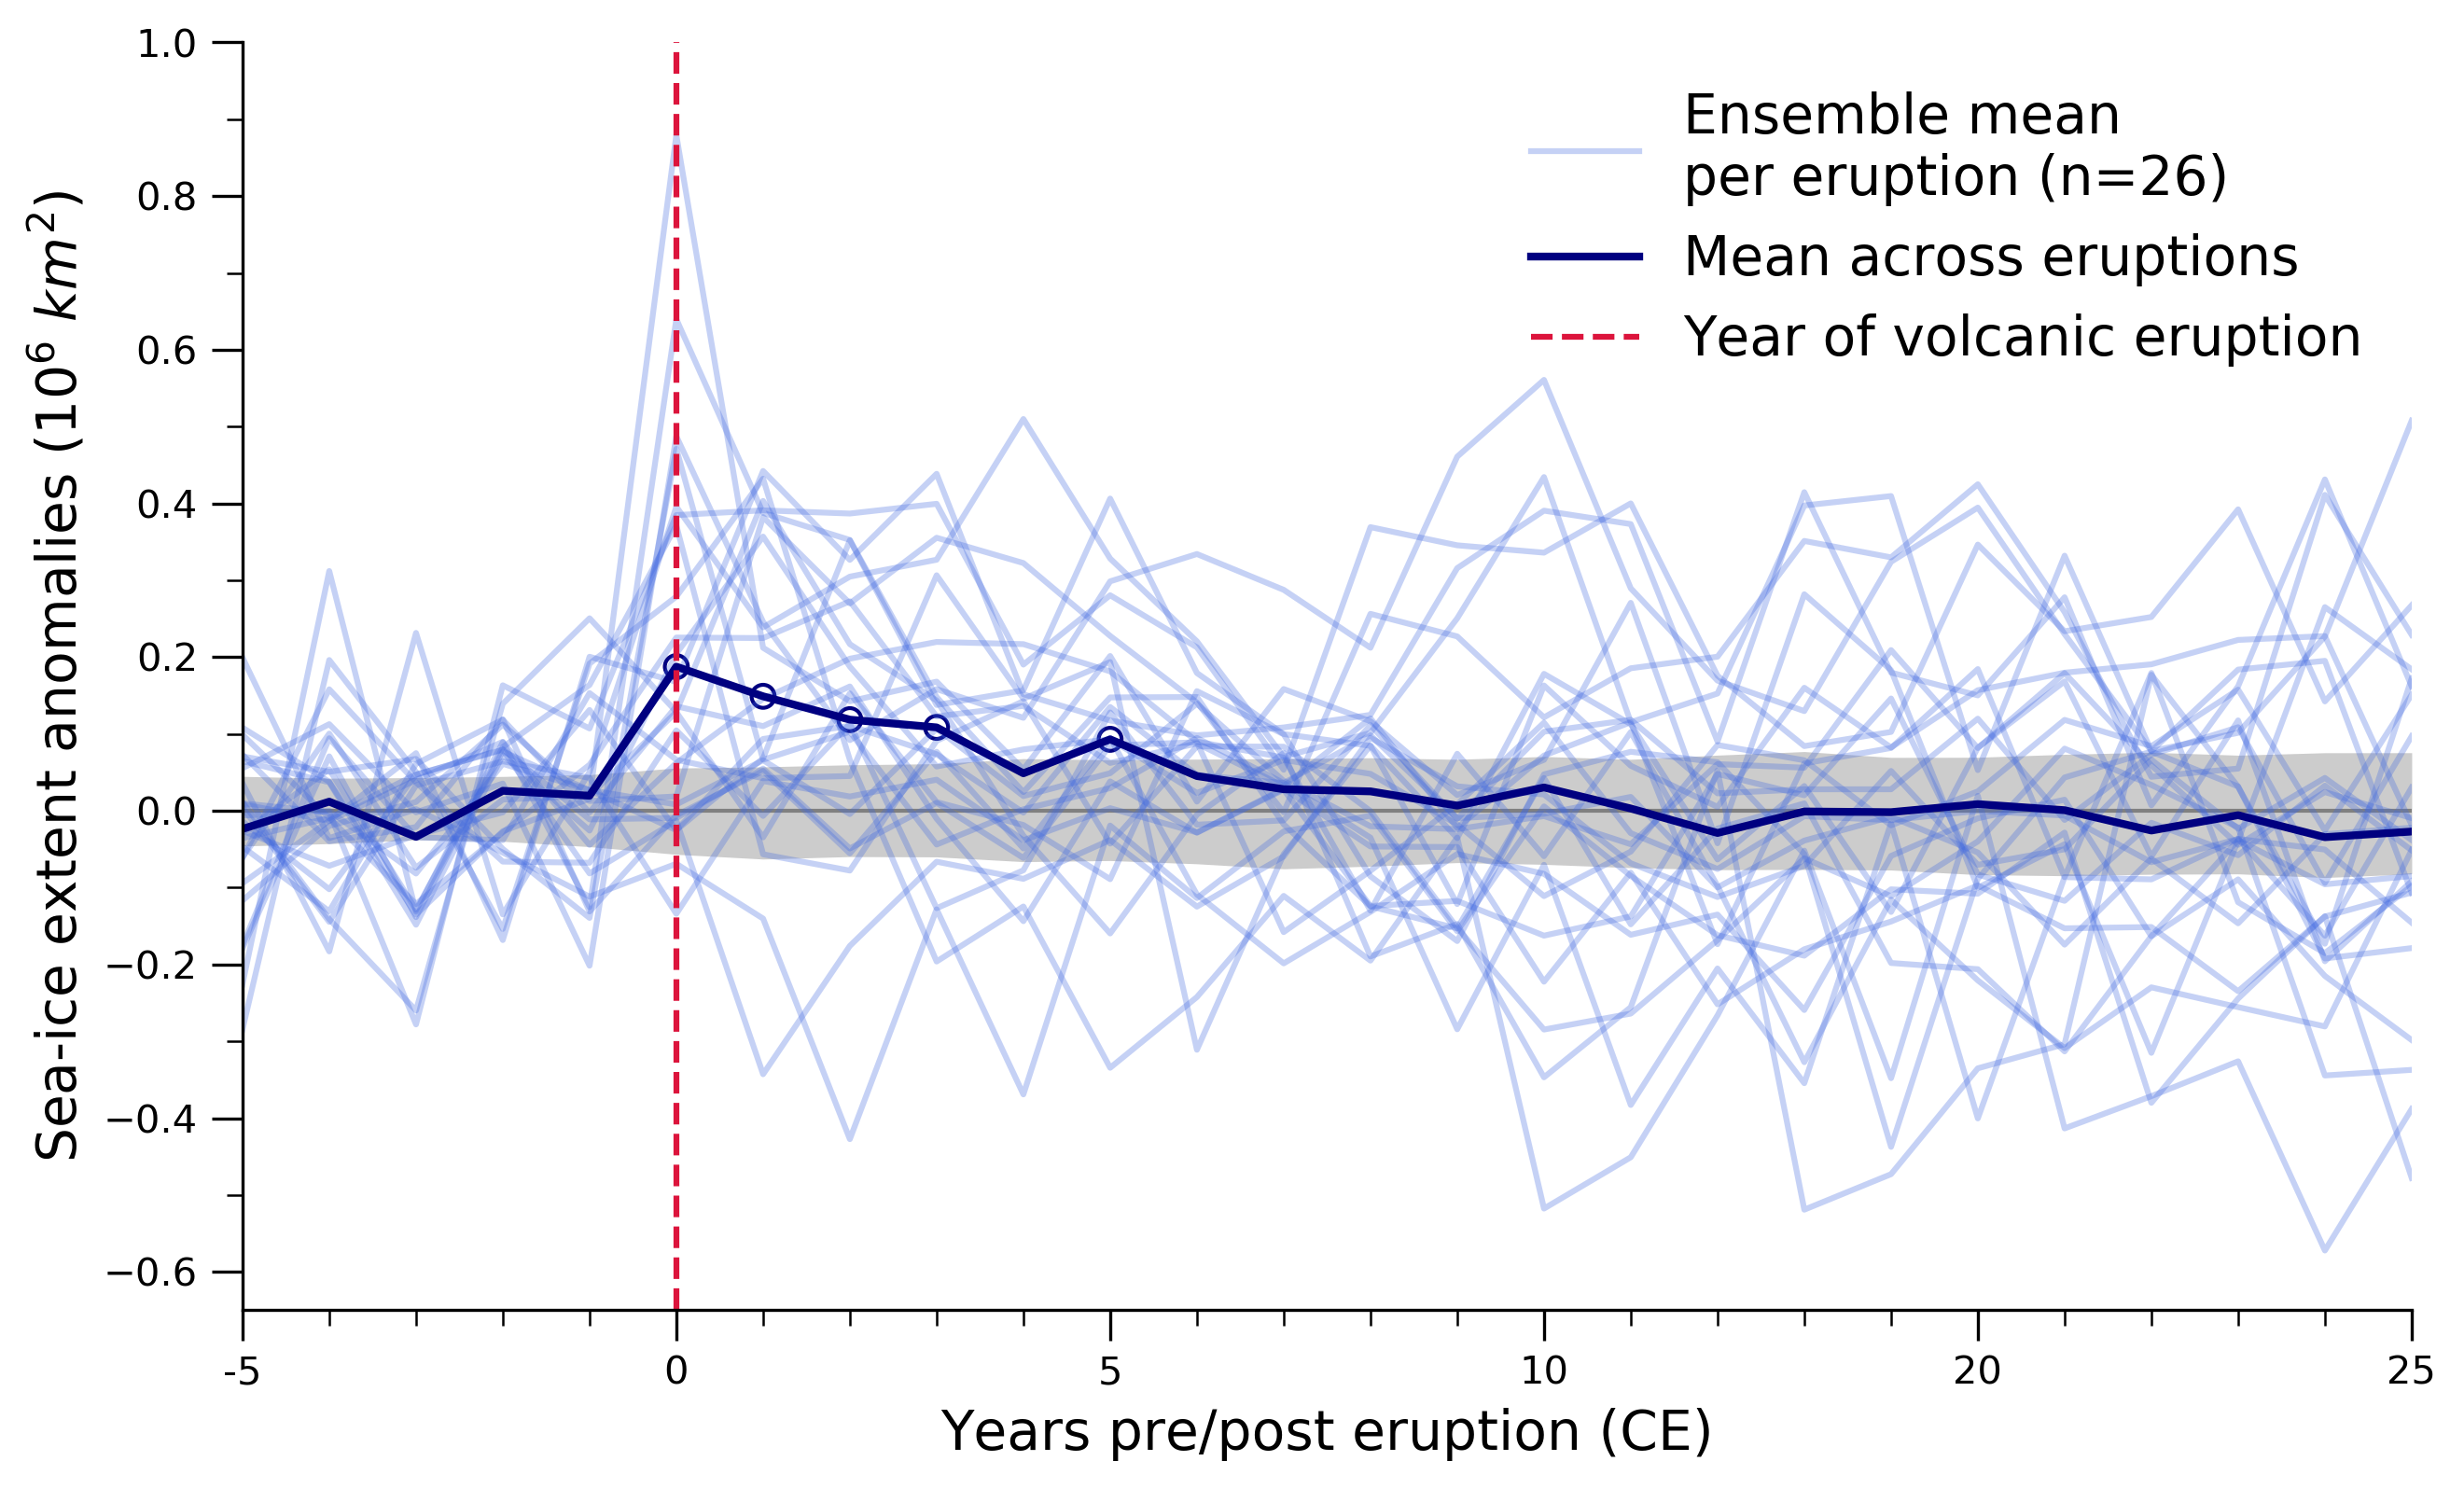

In [24]:
fig = plt.figure(figsize=(10,6))
plt.axhline(0, linestyle='-',color='gray', linewidth=1)

plt.fill_between(np.arange(0,26,1),sie_allit_randcomp_ensmn_2_5, sie_allit_randcomp_ensmn_97_5,
                 color='gray',alpha=0.4 ,lw=0.01)

for i in range(nvolc):
    if i is 0: 
        lab = 'Ensemble mean \nper eruption (n=26)'
    else: 
        lab = ''
    plt.plot(np.arange(0,26,1),sie_enmn_allvolc[:,i], color='royalblue', alpha=0.3,
             label=lab, linewidth=1.5)
plt.plot(np.arange(0,26,1),np.nanmean(sie_enmn_allvolc,axis=1), 
         color='navy', linewidth=2, label='Mean across eruptions')

for yr in range(26):
    if ttest_sig[yr] == True: 
        plt.scatter(yr,np.nanmean(sie_enmn_allvolc,axis=1)[yr], color='navy',
                    marker='o', s=35, facecolors='none')

x = [0,5,10,15,20,25,30]
labels = [-5,0,5,10,20,25]
plt.xticks(x,labels)
plt.xlabel('Years pre/post eruption (CE)', fontsize=14)
plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)', fontsize=14)

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(5,color='crimson', linestyle='--', linewidth=1.5, label='Year of volcanic eruption')

plt.legend(frameon=False, fontsize=14)
plt.xlim(0,25)
plt.ylim(-0.65,1.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'volc_sigl_2015_large_norep_composite.png'
#plt.savefig(savedir+savename)

## MPI Composite: 

In [34]:
nvolc = len(volc_40_time_norep)
sie_allit_volc_mpi = np.zeros((26,nvolc,2000))

for i,volc_yr in enumerate(volc_40_time_norep):
    mn = np.nanmean(sie_mpi_anom[int(volc_yr-5):volc_yr,:],axis=0) 
    sie_allit_volc_mpi[:,i,:] = sie_mpi_anom[int(volc_yr-5):int(volc_yr+21),:] - mn

sie_allit_volc_2d_mpi = np.reshape(sie_allit_volc,(26,nvolc*2000))
sie_enmn_allvolc_2d_mpi = np.nanmean(sie_allit_volc_2d,axis=1)

In [35]:
sz = 26
sie_allit_randcomp_ensmn = np.zeros((1000,26))

for rn in range(1000):
    sigtest_yrs = np.random.randint(5,2000-21,size=sz)
    sie_allit_randcomp = np.zeros((26,sz,2000))

    for i,volc_yr in enumerate(sigtest_yrs):
        mn = np.nanmean(sie_mpi_anom[int(volc_yr-5):volc_yr,:],axis=0) 
        sie_allit_randcomp[:,i,:] = sie_mpi_anom[int(volc_yr-5):int(volc_yr+21),:] - mn

    sie_allit_randcomp_ensmn[rn, :] = np.nanmean(np.nanmean(sie_allit_randcomp,axis=2),axis=1)

### Significance Testing: 

In [40]:
sie_enmn_allvolc_mpi = np.nanmean(sie_allit_volc_mpi,axis=2)

stat_mpi, p_mpi = stats.ttest_1samp(sie_enmn_allvolc_mpi,0, axis=1)
ttest_sig_mpi = (p_mpi<0.05)

In [37]:
sz = 26
sie_allit_randcomp_ensmn_mpi = np.zeros((1000,26))

for rn in range(1000):
    sigtest_yrs = np.random.randint(5,2000-21,size=sz)
    sie_allit_randcomp_mpi = np.zeros((26,sz,2000))

    for i,volc_yr in enumerate(sigtest_yrs):
        mn_mpi = np.nanmean(sie_mpi_anom[int(volc_yr-5):volc_yr,:],axis=0) 
        sie_allit_randcomp_mpi[:,i,:] = sie_mpi_anom[int(volc_yr-5):int(volc_yr+21),:] - mn_mpi

    sie_allit_randcomp_ensmn_mpi[rn, :] = np.nanmean(np.nanmean(sie_allit_randcomp_mpi,axis=2),axis=1)

In [38]:
sie_allit_randcomp_ensmn_97_5_mpi = np.percentile(sie_allit_randcomp_ensmn_mpi,97.5,axis=0)
sie_allit_randcomp_ensmn_2_5_mpi = np.percentile(sie_allit_randcomp_ensmn_mpi,2.5,axis=0)

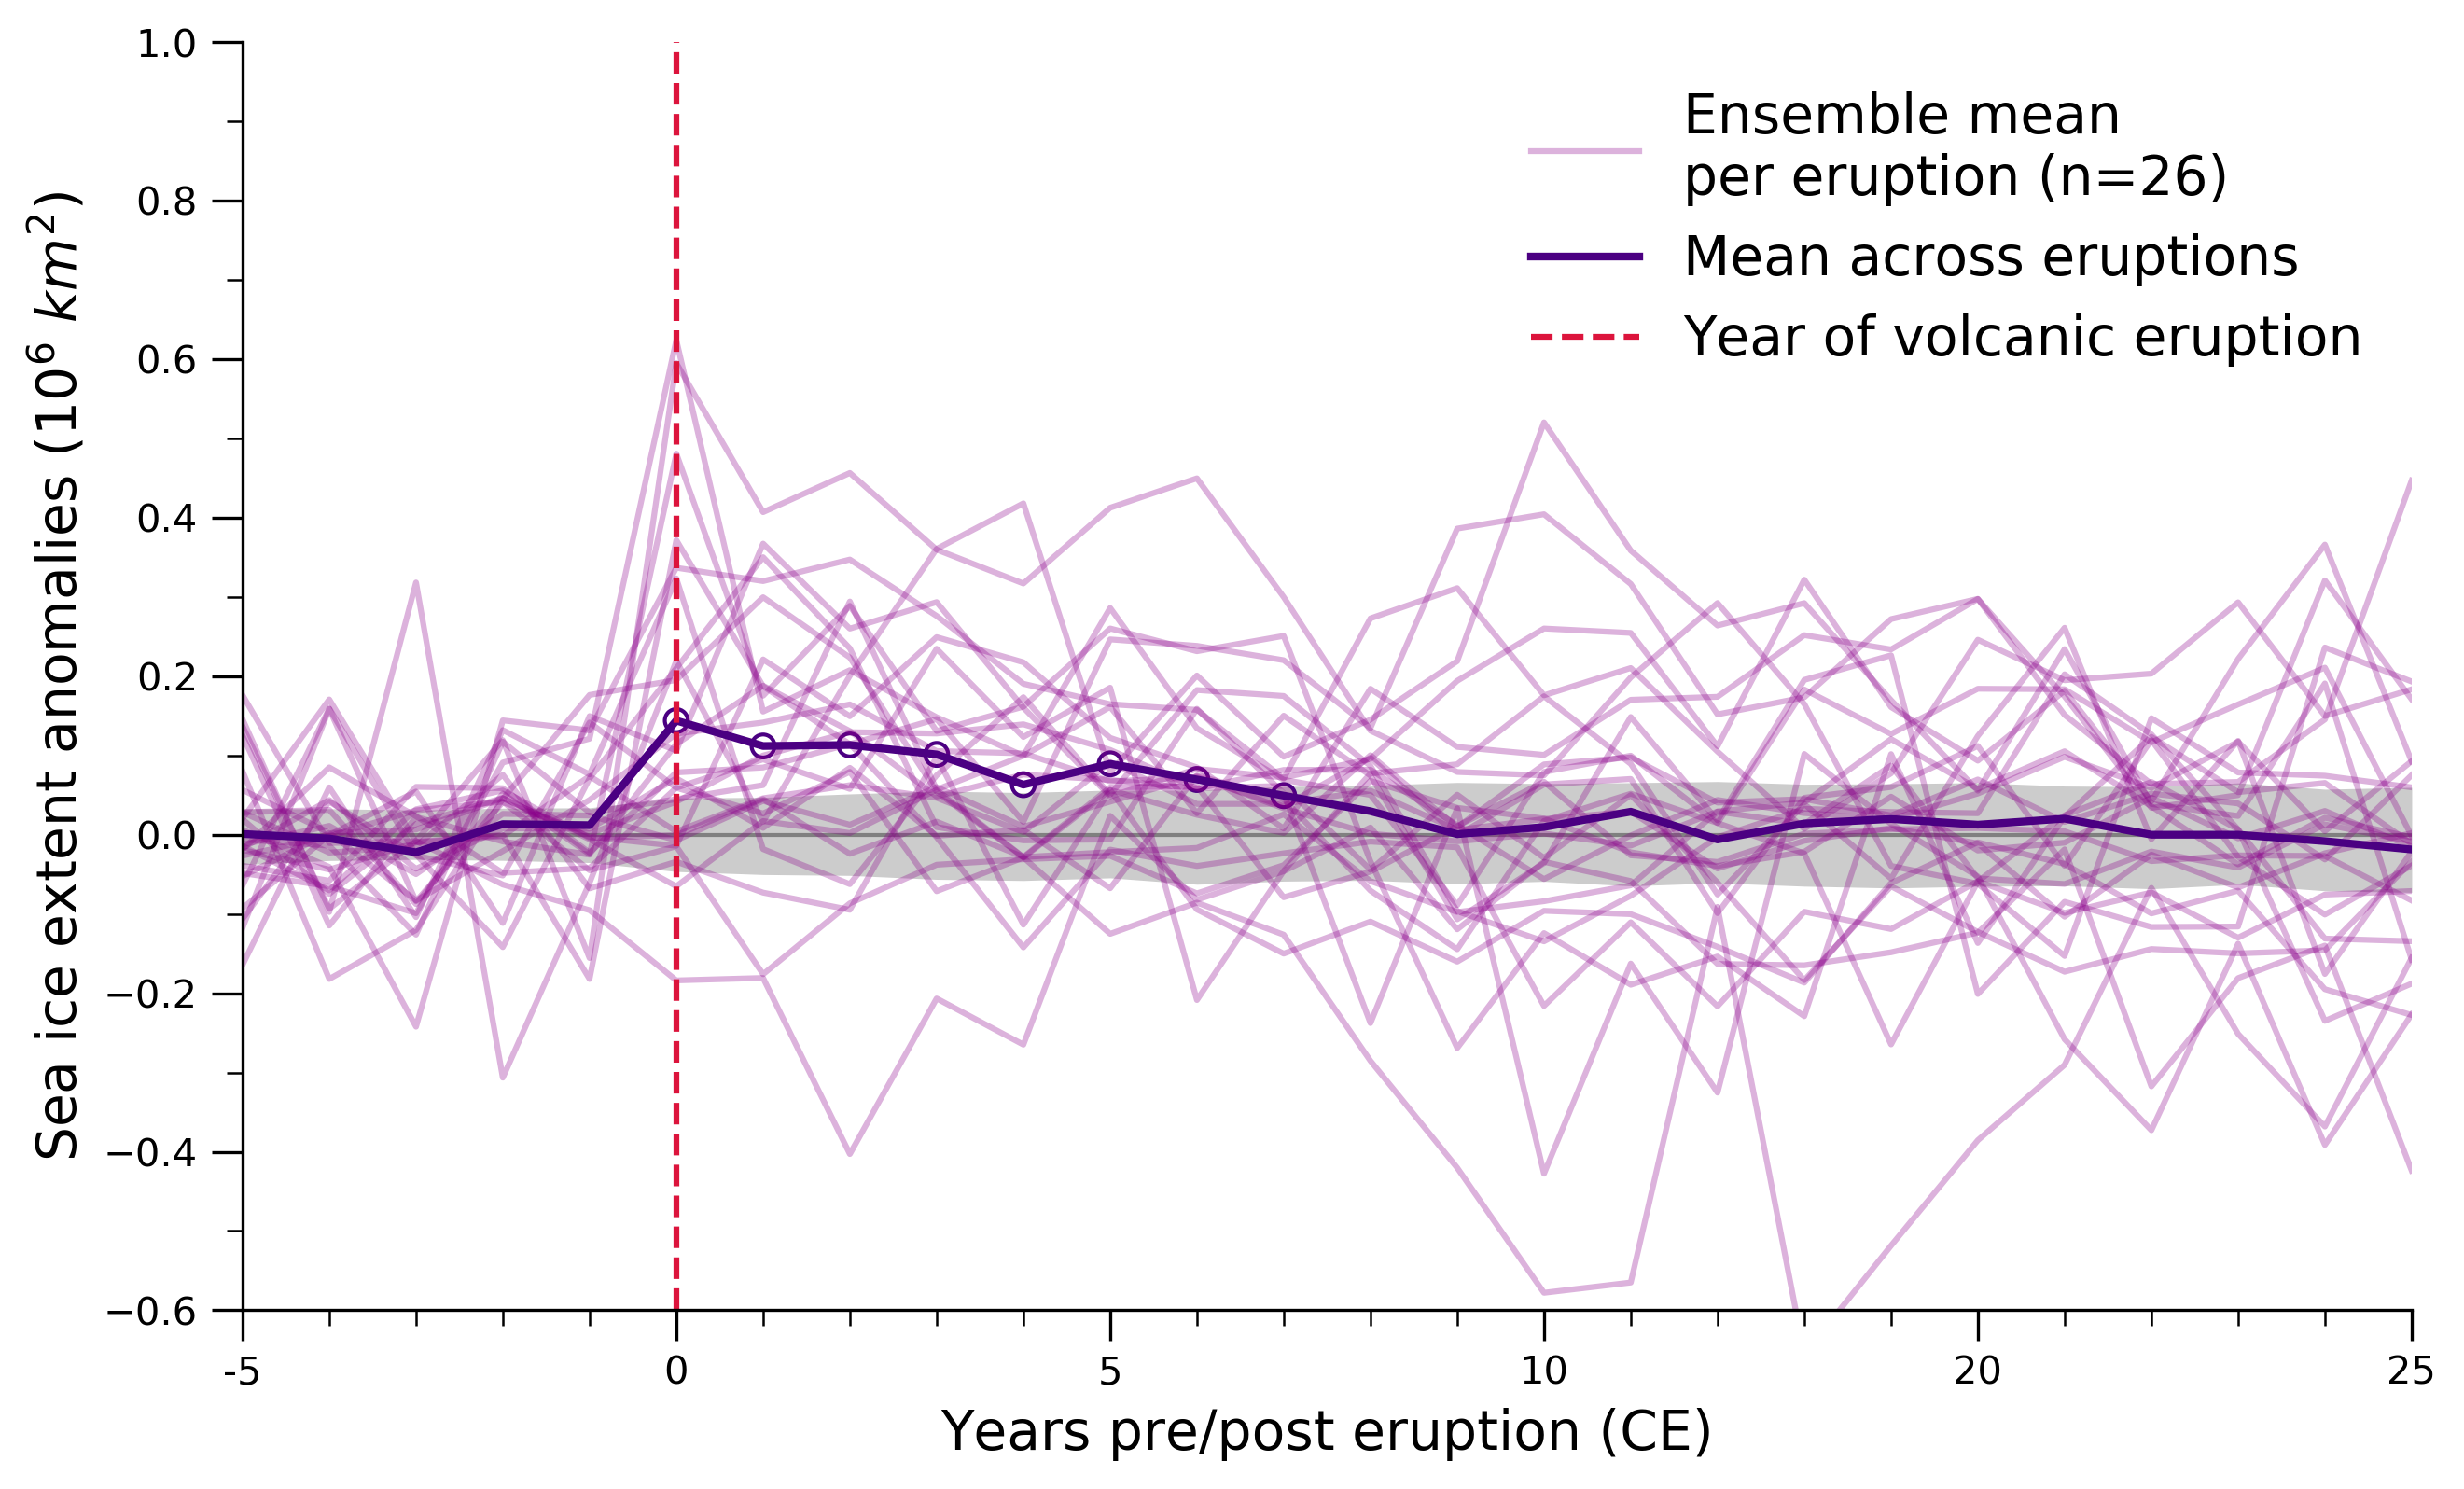

In [39]:
fig = plt.figure(figsize=(10,6))
plt.axhline(0, linestyle='-',color='gray', linewidth=1)
        
plt.fill_between(np.arange(0,26,1),sie_allit_randcomp_ensmn_2_5_mpi, sie_allit_randcomp_ensmn_97_5_mpi,
                 color='gray',alpha=0.4 ,lw=0.01)

for i in range(nvolc):
    if i is 0: 
        lab = 'Ensemble mean \nper eruption (n=26)'
    else: 
        lab = ''
    plt.plot(np.arange(0,26,1),sie_enmn_allvolc_mpi[:,i], color='darkmagenta', alpha=0.3,
             label=lab, linewidth=1.5)
plt.plot(np.arange(0,26,1),np.nanmean(sie_enmn_allvolc_mpi,axis=1), 
         color='indigo', linewidth=2, label='Mean across eruptions')

for yr in range(26):
    if ttest_sig_mpi[yr] == True: 
        plt.scatter(yr,np.nanmean(sie_enmn_allvolc_mpi,axis=1)[yr], color='indigo',
                    marker='o', s=35, facecolors='none')

x = [0,5,10,15,20,25,30]
labels = [-5,0,5,10,20,25]
plt.xticks(x,labels)
plt.xlabel('Years pre/post eruption (CE)', fontsize=14)
plt.ylabel('Sea ice extent anomalies (10$^{6}$ $km^2$)', fontsize=14)

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(5,color='crimson', linestyle='--', linewidth=1.5, label='Year of volcanic eruption')

plt.legend(frameon=False, fontsize=14)
plt.xlim(0,25)
plt.ylim(-0.6,1.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'volc_sigl_2015_large_norep_composite_mpi.png'
#plt.savefig(savedir+savename)

## Figure S11

In [28]:
sigl_topnh_full_forc_norep = np.zeros((2001))
sigl_toptrop_full_forc_norep = np.zeros((2001))

for yr in volc_40_time_norep: 
    if yr in list(sigl_40lg_yr_nh):
        sigl_topnh_full_forc_norep[yr] = sigl_40lg_forc_full[yr]
    elif yr in list(sigl_40lg_yr_trop):
        sigl_toptrop_full_forc_norep[yr] = sigl_40lg_forc_full[yr]

In [29]:
Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
sie_ccsm4_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_ccsm4)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


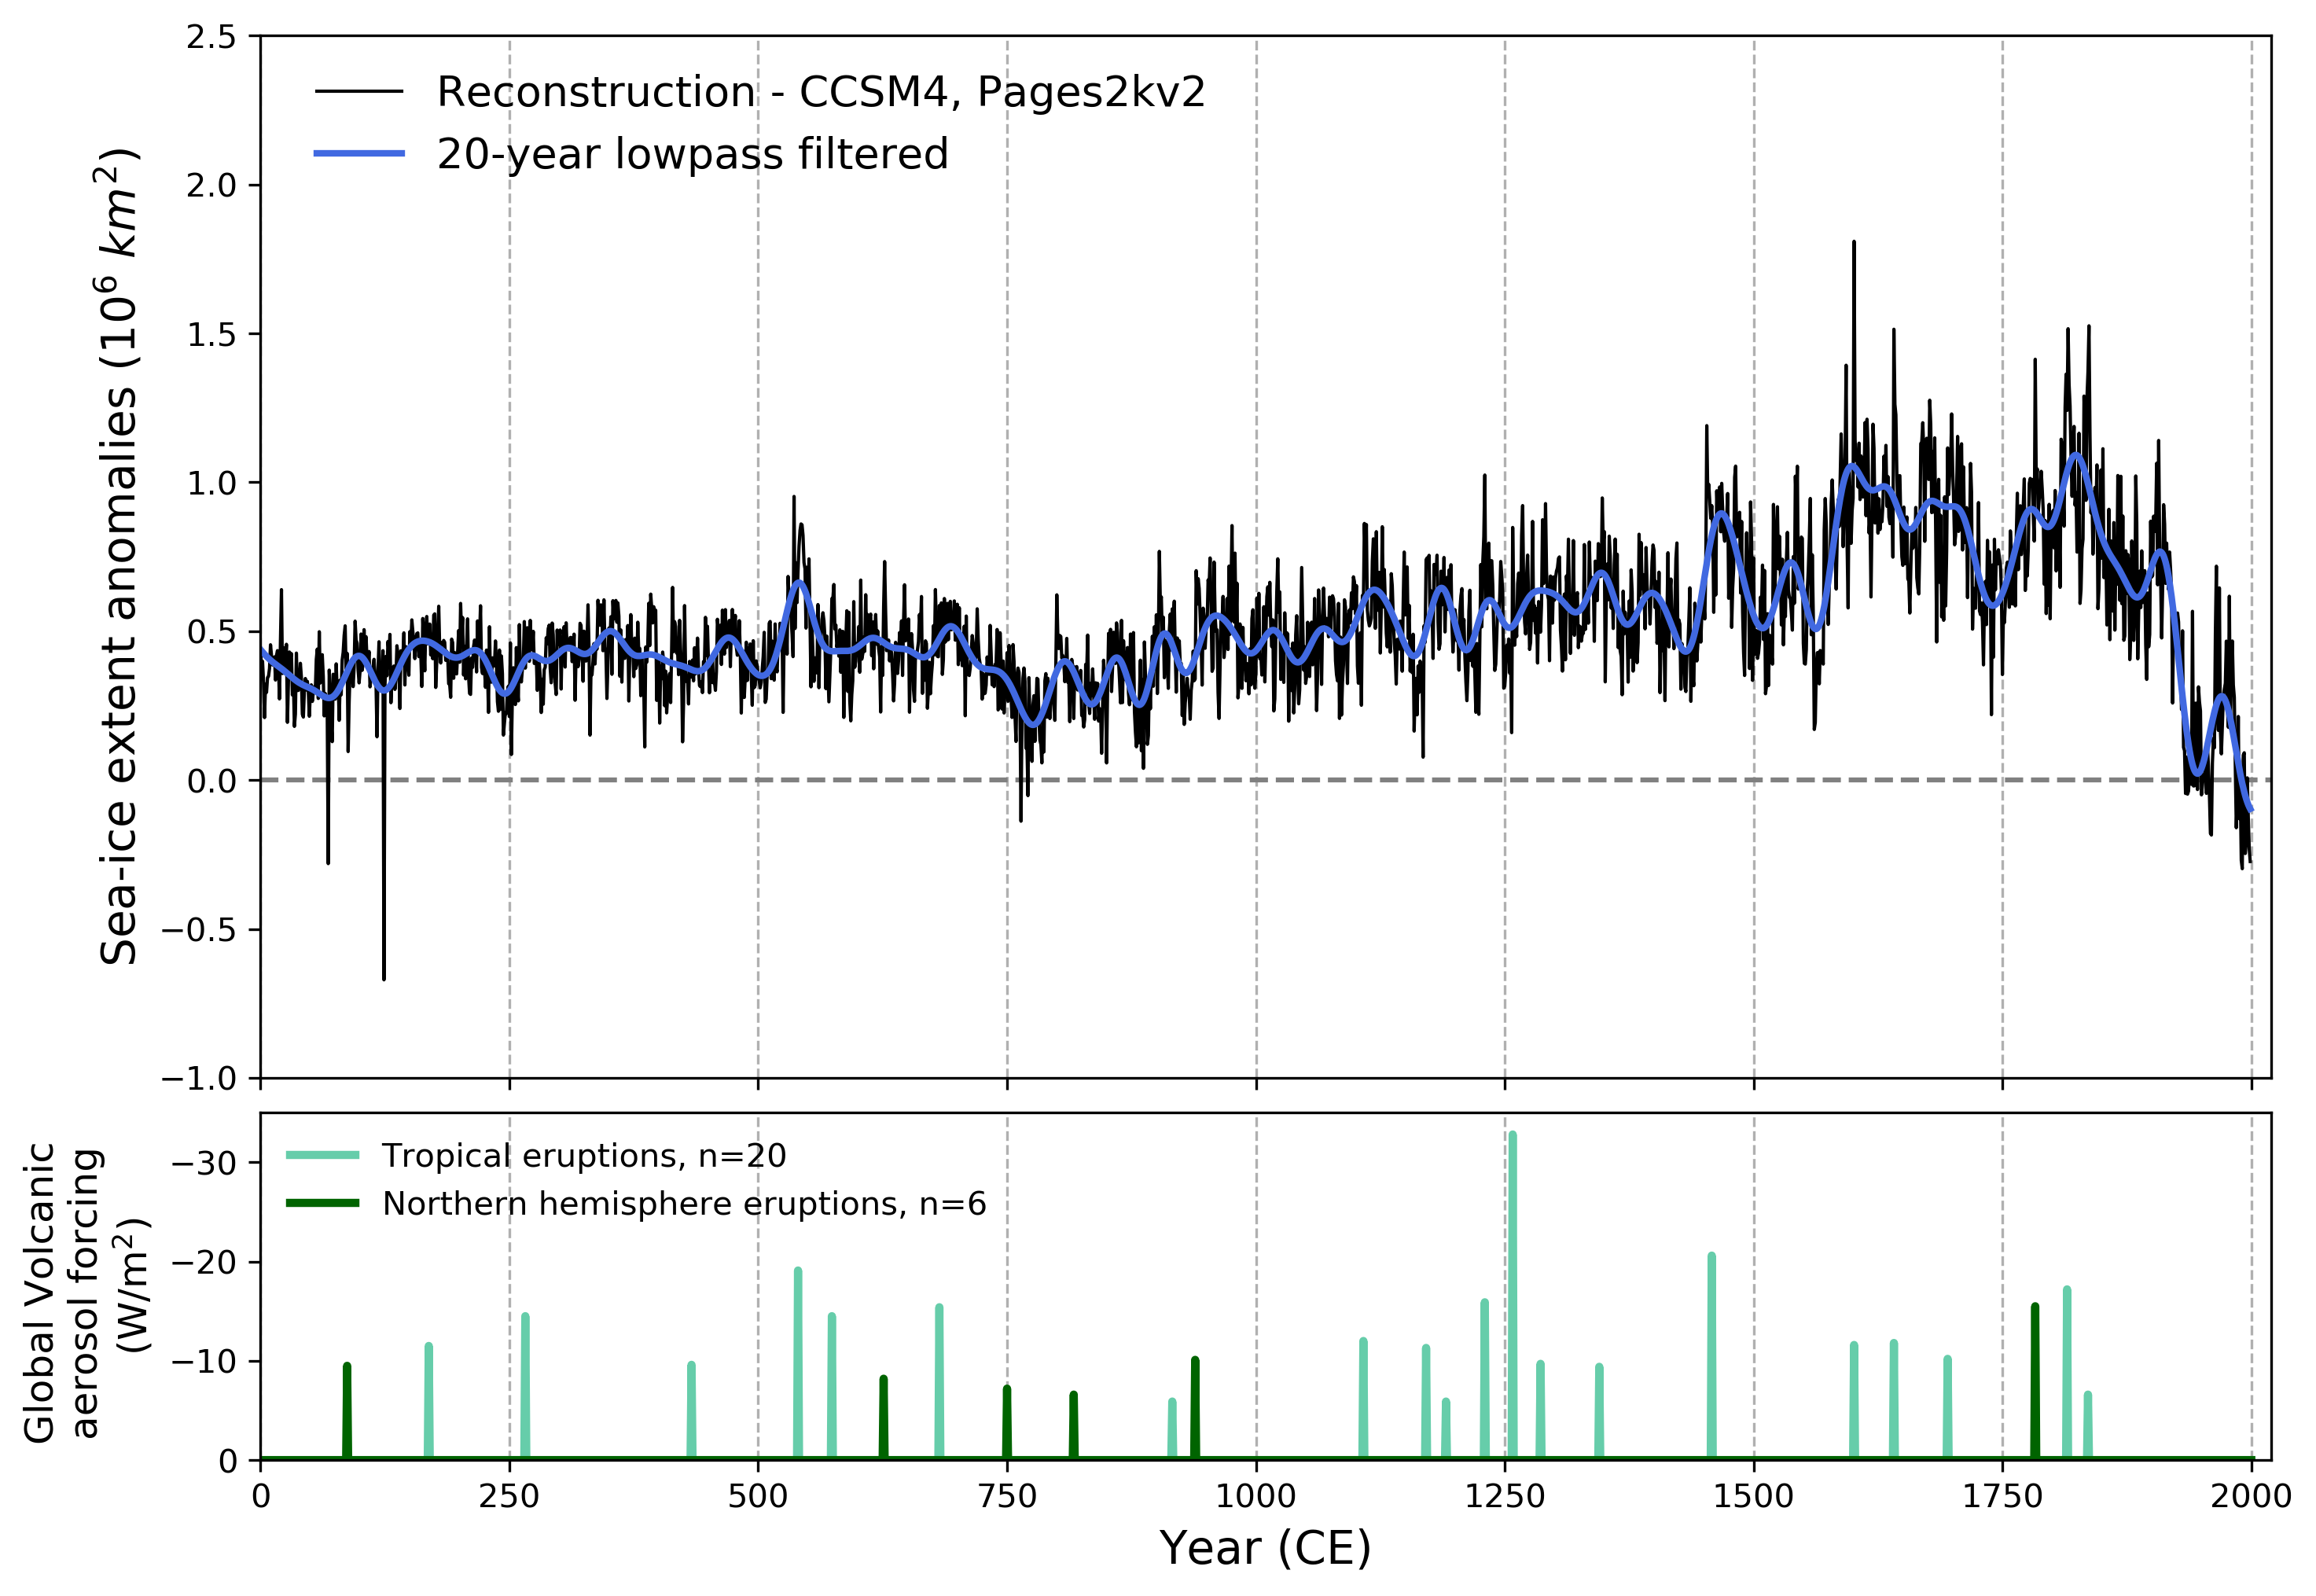

In [33]:
fig, (ax_recon,ax_prox) = plt.subplots(2, figsize=(11,8),sharex=True,
                                       gridspec_kw={"height_ratios": (.75,.25)})

ax_recon.axhline(0,linestyle='--',color='grey')

#ax_recon.fill_between(recon_years_ccsm4,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,color='gray',lw=0.01,alpha=0.5)

# ax_recon.axvline(1450)
# ax_recon.axvline(1850)

ax_recon.plot(recon_data_ccsm4.time.values,sie_ensmn_anom_ccsm4,color='k',#'#107ab0',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=1)
ax_recon.plot(recon_data_ccsm4.time.values,sie_ccsm4_filt20,color='royalblue',#'#107ab0',
         label='20-year lowpass filtered',linewidth=2)

ax_recon.set_ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
#ax_recon.set_xlabel('Year (CE)',fontsize=14)

ax_recon.legend(fontsize=13,bbox_to_anchor=(0.49, 1),frameon=False)
#plt.ylim(7,13.1,1)

ax_recon.set_xlim(0,2020)
ax_recon.set_ylim(-1.0,2.5)

sigl_40lg_yr_nh
ax_prox.plot(sigl_toptrop_full_forc_norep, label='Tropical eruptions, n=20',
             color='mediumaquamarine', linewidth=2.5)
ax_prox.plot(sigl_topnh_full_forc_norep, label='Northern hemisphere eruptions, n=6',
             color='darkgreen', linewidth=2.5)
ax_prox.set_xlabel('Year (CE)', fontsize=14)
ax_prox.set_ylabel('Global Volcanic \naerosol forcing \n(W/m$^2$)', fontsize=12)
ax_prox.invert_yaxis()
ax_prox.set_ylim(0,-35)
ax_prox.legend(loc='upper left', frameon=False)

ax_prox.xaxis.grid(linestyle='--')
ax_recon.xaxis.grid(linestyle='--')

plt.subplots_adjust(wspace=0, hspace=0.05)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Recon_ccsm4_0_2000_volc_40large_sigl_norep.png'
plt.savefig(savedir+savename)